Esteban González

Paso 1: importamos las librerías basicas para el procesamiento de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix
import pickle
import preproc_nyc_sqf as sqf
import missingno as msngo
import operator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
pd.options.display.max_rows = 200

Paso 2: Importamos los dataframes y dropeamos las variables unnamed:0

In [2]:
df_2009 = pd.read_csv('2009_1perc.csv').drop(columns='Unnamed: 0')
df_2010 = pd.read_csv('2010_1perc.csv').drop(columns='Unnamed: 0')

Paso 2.1: Obtenemos las dimensiones de los dataframes cargados

In [3]:
df_2009.shape, df_2010.shape

((5812, 111), (6013, 111))

Paso 2.2: Realizamos un mapeo de la cantdad de variables, y los dtypes

In [4]:
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5812 entries, 0 to 5811
Columns: 111 entries, year to detailcm
dtypes: float64(1), int64(18), object(92)
memory usage: 4.9+ MB


Paso 2.3: preprocesamos los dataframes a través de la función create_suitable_dataframe, y revisamos los tipos de variables

In [5]:
sqf.create_suitable_dataframe(df_2009)
save_2009,_,_ = sqf.create_suitable_dataframe(df_2009)
df_save_2009 = pd.DataFrame(save_2009)
print('\n')
df_2009.info()

['perobs']
['perobs', 'meters', 'age_individual']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5812 entries, 0 to 5811
Columns: 114 entries, year to age_individual
dtypes: float64(3), int64(19), object(92)
memory usage: 5.1+ MB


Paso 2.4: Revisamos la cantidad de categorías que tiene las variables nominales

In [6]:
x = sqf.count_freq(df_2009, df_2009.select_dtypes('object').columns)
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

In [7]:
sorted_x

[('ycoord', 4430),
 ('xcoord', 4346),
 ('crossst', 1686),
 ('stinter', 1595),
 ('addrnum', 1431),
 ('stname', 977),
 ('premname', 562),
 ('crimsusp', 388),
 ('sumoffen', 192),
 ('arstoffn', 164),
 ('post', 83),
 ('beat', 34),
 ('sector', 18),
 ('haircolr', 11),
 ('eyecolor', 10),
 ('race', 8),
 ('build', 5),
 ('city', 5),
 ('trhsloc', 4),
 ('typeofid', 4),
 ('sex', 3),
 ('recstat', 2),
 ('inout', 2),
 ('explnstp', 2),
 ('othpers', 2),
 ('arstmade', 2),
 ('sumissue', 2),
 ('offunif', 2),
 ('frisked', 2),
 ('searched', 2),
 ('contrabn', 2),
 ('pistol', 2),
 ('riflshot', 2),
 ('asltweap', 2),
 ('knifcuti', 2),
 ('othrweap', 2),
 ('pf_hands', 2),
 ('pf_wall', 2),
 ('pf_grnd', 2),
 ('pf_drwep', 2),
 ('pf_ptwep', 2),
 ('pf_baton', 2),
 ('pf_hcuff', 2),
 ('pf_pepsp', 2),
 ('pf_other', 2),
 ('radio', 2),
 ('ac_rept', 2),
 ('ac_inves', 2),
 ('rf_vcrim', 2),
 ('rf_othsw', 2),
 ('ac_proxm', 2),
 ('rf_attir', 2),
 ('cs_objcs', 2),
 ('cs_descr', 2),
 ('cs_casng', 2),
 ('cs_lkout', 2),
 ('rf_vcact',

- Podemos ver que existen muchas variables constantes (variables que tienen una sola categoría, como por ejemplo zip, rescode, etc) y otras con mucha dimensionalidad, cuya cantidad de categorías dificulta el trabajo, al momento de binarizar las variables.

- Graficamos la variables enteras y decimales, para ver la distribución y observar si existe un sesgo

In [8]:
def grid_plot_batch(df, cols, plot_type):

    """
    grid_plot_batch: Genera una grilla matplotlib para cada conjunto de variables.

    Parámetros de ingreso:
        - df: un objeto pd.DataFrame
        - cols: cantidad de columnas en la grilla.
        - plot_type: tipo de gráfico a generar. Puede ser una instrucción genérica de matplotlib o seaborn.

    Retorno:
        - Una grilla generada con plt.subplots y las instrucciones dentro de cada celda.

    """
    # calcular un aproximado a la cantidad de filas
    rows = np.ceil(df.shape[1] / cols)

    # para cada columna
    for index, (colname, serie) in enumerate(df.iteritems()):
        plt.subplot(rows, cols, index + 1)
        plot_type(serie)
        plt.tight_layout()

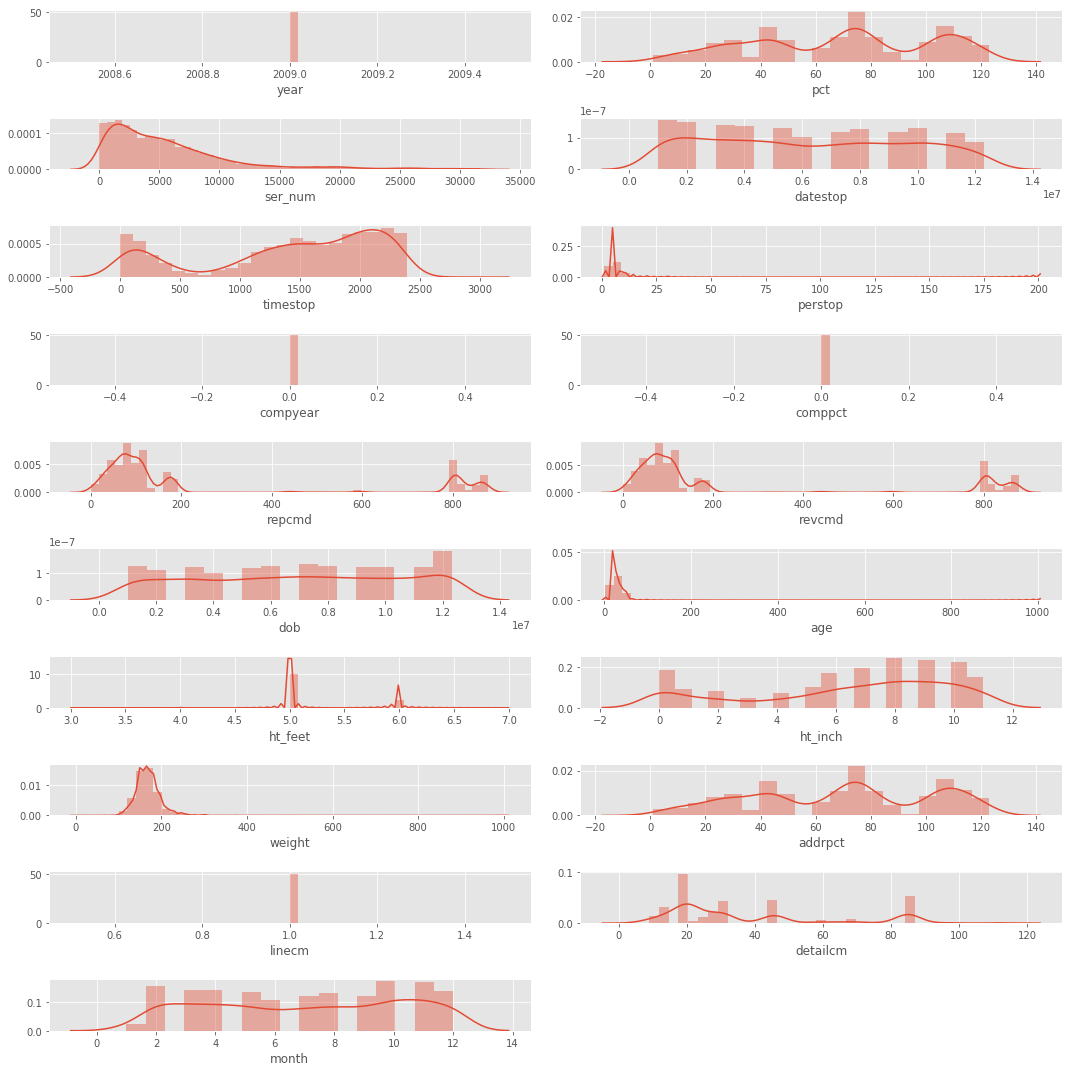

In [9]:
plt.rcParams['figure.figsize'] = (15, 15)
grid_plot_batch(df_2009.select_dtypes('integer'), 2, sns.distplot)

- Existen variables enteras que hay que limpiar, porque son constantes. Tambien se puede ver existe sesgo en varias varables. Guardamos las variables enteras que deben ser escaladas en el futuro.

In [10]:
var_enteras = df_2009.select_dtypes('integer').columns
var_enteras.drop(['year','compyear','comppct','linecm'])

Index(['pct', 'ser_num', 'datestop', 'timestop', 'perstop', 'repcmd', 'revcmd',
       'dob', 'age', 'ht_feet', 'ht_inch', 'weight', 'addrpct', 'detailcm',
       'month'],
      dtype='object')

Iniciamos la limpieza del dataframe. para asegurar que ambos dataframes tengan la misma estructura de columnas. Estos seran
concatenados para realizar la limpieza de variables. Iniciamos concatenando ambos Dataframes, para que tanto train como test, ambos tengan la misma dimensionalidad.

In [11]:
df_concat = pd.concat([df_2009,df_2010])
df_concat.columns

Index(['ac_assoc', 'ac_cgdir', 'ac_evasv', 'ac_incid', 'ac_inves', 'ac_other',
       'ac_proxm', 'ac_rept', 'ac_stsnd', 'ac_time',
       ...
       'sumissue', 'sumoffen', 'timestop', 'trhsloc', 'typeofid', 'weight',
       'xcoord', 'ycoord', 'year', 'zip'],
      dtype='object', length=114)

Vemos la información general del nuevo dataset concatenado.

In [12]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11825 entries, 0 to 6012
Columns: 114 entries, ac_assoc to zip
dtypes: float64(4), int64(15), object(95)
memory usage: 10.4+ MB


Preprocesamos el dataset concatenado. Para posteriormente efectuar la limpieza de las variables nulas

In [13]:
sqf.create_suitable_dataframe(df_concat)

['age_individual', 'meters', 'month', 'perobs']


(     ac_assoc ac_cgdir ac_evasv ac_incid ac_inves ac_other ac_proxm ac_rept  \
 0           N        N        N        N        N        N        Y       N   
 2           N        N        N        Y        N        N        N       N   
 3           N        N        N        Y        N        N        N       N   
 5           N        N        N        N        N        N        N       N   
 6           N        N        N        Y        N        N        Y       N   
 8           N        N        N        N        N        Y        Y       Y   
 9           N        Y        N        N        N        N        N       N   
 10          N        Y        N        Y        N        N        N       N   
 11          N        Y        N        Y        N        N        N       N   
 12          N        N        N        Y        Y        N        N       N   
 14          N        N        N        Y        N        N        N       N   
 16          N        N        N        

In [14]:
#visualizamos la cantidad de datos perdidos por cada variables del dataframe
df_concat.isnull().sum()

ac_assoc             0
ac_cgdir             0
ac_evasv             0
ac_incid             0
ac_inves             0
ac_other             0
ac_proxm             0
ac_rept              0
ac_stsnd             0
ac_time              0
addrnum              0
addrpct              0
addrtyp              0
adtlrept             0
age                  0
age_individual    2440
aptnum               0
arstmade             0
arstoffn             0
asltweap             0
beat                 0
build                0
city                 0
comppct              0
compyear             0
contrabn             0
crimsusp             0
crossst              0
cs_bulge             0
cs_casng             0
cs_cloth             0
cs_descr             0
cs_drgtr             0
cs_furtv             0
cs_lkout             0
cs_objcs             0
cs_other             0
cs_vcrim             0
datestop             0
detailcm             0
dettypcm             0
dob                  0
explnstp             0
eyecolor   

Como se puede ver, la mayoria de los valores perdidos se concentra en la edad del individuo. Utilizamos la matriz de valores perdidos de msngo para visualizarlas.

<Figure size 288x288 with 0 Axes>

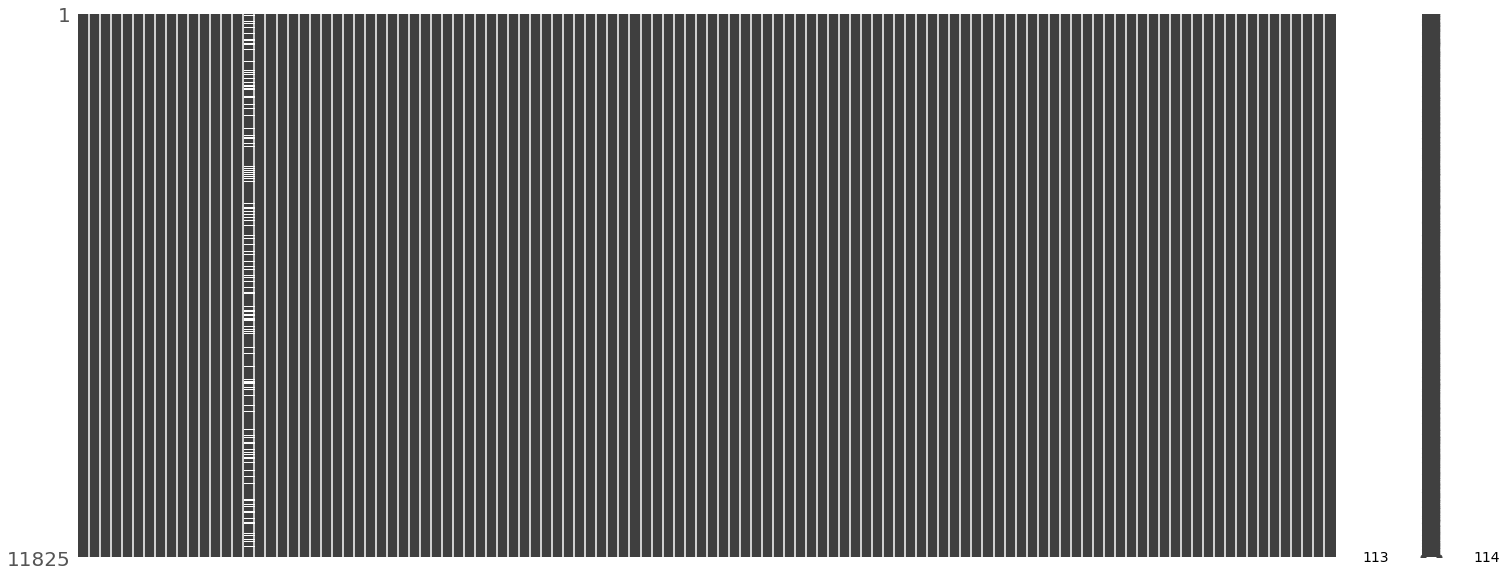

In [15]:
plt.figure(figsize=(4,4))
msngo.matrix(df_concat)

Dropeamos los valores perdidos

In [16]:
df_concat = df_concat.dropna()

Generamos los atributos target para el hito 3 y para el hito 4. Para el hito 3, binarizamos la variable "arstmade"

In [17]:
df_concat['target1'] = np.where(df_concat['arstmade']=='N',0,1)

Para el hito 4: recodificamos las variables que definen el grado de violencia, la sumamos, binarizamos este resultado dropeamos las variables originales, para dejar solo el target 2

In [18]:
#binarizar
df_concat['pf_hands'] = np.where(df_concat['pf_hands']=='N',0,1)
df_concat['pf_wall'] = np.where(df_concat['pf_wall']=='N',0,1)
df_concat['pf_grnd'] = np.where(df_concat['pf_grnd']=='N',0,1)
df_concat['pf_drwep'] = np.where(df_concat['pf_drwep']=='N',0,1)
df_concat['pf_baton'] = np.where(df_concat['pf_baton']=='N',0,1)
df_concat['pf_hcuff'] = np.where(df_concat['pf_hcuff']=='N',0,1)
df_concat['pf_pepsp'] = np.where(df_concat['pf_pepsp']=='N',0,1)
df_concat['pf_other'] = np.where(df_concat['pf_other']=='N',0,1)

#Agregar variables binarias
df_concat['target2']=df_concat['pf_hands']+df_concat['pf_wall']+df_concat['pf_grnd']+df_concat['pf_drwep']+df_concat['pf_baton']+df_concat['pf_hcuff']+df_concat['pf_pepsp']+df_concat['pf_other']

#binarizamos la variable target2
df_concat['target2'] = np.where(df_concat['target2']==0,0,1)

#Se dropean las variables originales
df_concat = df_concat.drop(columns=['pf_hands','pf_wall','pf_grnd','pf_drwep','pf_baton','pf_hcuff','pf_pepsp','pf_other','arstmade'],axis=1)

- Una vez realizada la limpieza, revisamos las variables del dataframe. Separamos las variables objetos de las enteras en dataframes distintos

In [19]:
df_obj=pd.DataFrame()
df_nobj=pd.DataFrame()
for colname, series in df_concat.iteritems():
    if series.dtype=='object':
        df_obj= pd.concat([df_obj,series],axis=1)
    elif series.dtype== 'int64' or series.dtype== 'float64' or series.dtype== 'int32':
        df_nobj= pd.concat([df_nobj,series],axis=1)

Eliminamos los atributos que poseen 1 sola categoría, por ser constante, y no aportar a la predicción

In [20]:
borrado1 = []
for i in df_obj.columns:
    tmp = df_obj[i].unique()
    ndatos = len(tmp)
    if ndatos==1:
        borrado1.append(i)
        df_obj.drop(columns=i)

df_obj = df_obj.drop(columns=borrado1)

Eliminamos las variables que tienen más de 20 categorias, para reducir el costo de computo

In [21]:
borrado2 = []
for i in df_obj.columns:
    tmp = df_obj[i].unique()
    ndatos = len(tmp)
    if ndatos>20:
        borrado2.append(i)
        df_obj.drop(columns=i)

df_obj = df_obj.drop(columns=borrado2)
len(borrado2)

14

- Eliminamos las variables binarias cuya 1 de las categorias, tiene menos del 5%, dado que van a presentar poca información para la clasificación

In [22]:
ensayo_0=[]
borrado_0=[]
for i in df_obj.columns:
    tmp = df_obj[i].unique()
    ndatos = len(tmp)
    if ndatos==2:
        ensayo_0.append(i)
        for m in df_obj[i].value_counts('%').values:
            if m < 0.05:
                borrado_0.append(i)
                
df_obj = df_obj.drop(columns=borrado_0)

- de las variables enteras, eliminamos compyear, comppct, perobs y perstop por ser constantes y no aportar en la clasificación

In [23]:
df_nobj = df_nobj.drop(columns=['compyear','comppct','perobs','perstop'],axis=1)

Efectuamos las transformaciones finales al dataframe

In [24]:
#concatenamos ambos dataframe para crear el dataframe limpio
df_clean = pd.concat([df_nobj, df_obj], axis=1)

#recodificamos las variables nominales
objetos = df_clean.select_dtypes('object').columns
df_clean_recod = pd.get_dummies(data=df_clean, columns=objetos, drop_first=True, prefix=objetos)

#Dividimos las muestras de entrenamiento y testeo
df_train = df_clean_recod.query("year==2009")
df_test = df_clean_recod.query("year==2010")

#Dimensionamos ambos datasets
df_train.shape, df_test.shape

((4636, 111), (4747, 111))

Revisamos la distribución de la variable target 1

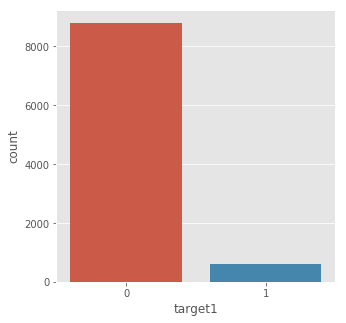

In [25]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.countplot(df_clean['target1'])

Vemos un claro desbalance entre las clases. Implementamos el algoritmo ADABoost, y probaremos un rebalanceo de las clases para generar modelos

Separamos las variables en Y y X segun los dataframe

In [26]:
y_train = df_train['target1']
x_train = df_train.drop(['target1','year'], axis=1)
y_test = df_test['target1']
x_test = df_test.drop(['target1','year'], axis=1)

Entrenamos un modelo adaboost sin balancear la muestra

In [27]:
# Entrenamos el decision stump
decision_stump = DecisionTreeClassifier(max_depth=1,random_state=16984).fit(x_train, y_train)
# Entrenamo el clasificador con adaptive boosting
Adaboost_model = GridSearchCV(AdaBoostClassifier(base_estimator=decision_stump,random_state=16984),{'learning_rate':[0.01,0.1,0.5],'n_estimators':[50, 100, 500, 1000, 2000]},cv=2,n_jobs=-1).fit(x_train, y_train)
# Obtenemos el best estimator
Adaboost_model.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=16984,
                            

Vemos los resultados del adaboost en el reporte de clasificación

In [28]:
y_hat = Adaboost_model.best_estimator_.predict(x_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4438
           1       0.64      0.29      0.40       309

    accuracy                           0.94      4747
   macro avg       0.79      0.64      0.68      4747
weighted avg       0.93      0.94      0.93      4747



Utilizamos metodos para rebalancear la data: oversampling y subsampling

In [29]:
#definimos el oversampler
oversmp = SMOTE(random_state=16984, ratio='minority')
x_train_oversmp, y_train_oversmp = oversmp.fit_sample(x_train, y_train)

df_train_oversmp = pd.DataFrame(x_train_oversmp)
df_train_oversmp.columns = x_train.columns
df_train_oversmp['target1']= y_train_oversmp

#definimos el undersampler
rus = RandomUnderSampler(sampling_strategy='majority',random_state=16984)
x_train_undersmp, y_train_undersmp = rus.fit_sample(x_train, y_train)

df_train_undersmp = pd.DataFrame(x_train_undersmp)
df_train_undersmp.columns = x_train.columns
df_train_undersmp['target1']= y_train_undersmp

x_train_oversmp.shape, x_train_undersmp.shape

((8710, 109), (562, 109))

Graficamos la variable target1, con oversampling

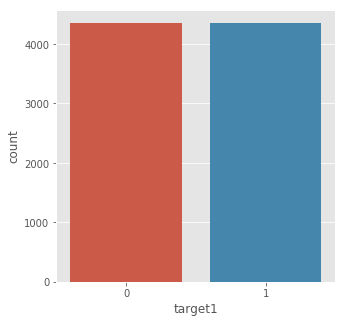

In [30]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.countplot(df_train_oversmp['target1'])

Graficamos la variable target1, con subsampling

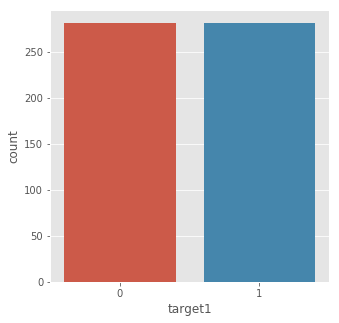

In [31]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.countplot(df_train_undersmp['target1'])

Adaboost con oversampling

In [32]:
# Entrenamos el decision stump
decision_stump = DecisionTreeClassifier(max_depth=1,random_state=16984).fit(x_train_oversmp, y_train_oversmp)
# Entrenamo el clasificador con adaptive boosting
Adaboost_model_over = GridSearchCV(AdaBoostClassifier(base_estimator=decision_stump,random_state=16984),{'learning_rate':[0.01,0.1,0.5],'n_estimators':[50, 100, 500, 1000, 2000]},cv=2,n_jobs=-1).fit(x_train_oversmp, y_train_oversmp)
Adaboost_model_over.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=16984,
                            

Vemos los resultados del adaboost en el reporte de clasificación

In [33]:
y_over_hat= Adaboost_model_over.best_estimator_.predict(x_test)
print(classification_report(y_test, y_over_hat))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4438
           1       0.60      0.54      0.57       309

    accuracy                           0.95      4747
   macro avg       0.78      0.76      0.77      4747
weighted avg       0.94      0.95      0.95      4747



Adaboost con undersampling

In [34]:
# Entrenamos el decision stump
decision_stump = DecisionTreeClassifier(max_depth=1,random_state=16984).fit(x_train_undersmp, y_train_undersmp)
# Entrenamo el clasificador con adaptive boosting
Adaboost_model_under = GridSearchCV(AdaBoostClassifier(base_estimator=decision_stump,random_state=16984),{'learning_rate':[0.01,0.1,0.5],'n_estimators':[50, 100, 500, 1000, 2000]},cv=2,n_jobs=-1).fit(x_train_undersmp, y_train_undersmp)
Adaboost_model_under.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=16984,
                            

Vemos los resultados del adaboost en el reporte de clasificación

In [35]:
y_under_hat= Adaboost_model_under.best_estimator_.predict(x_test)
print(classification_report(y_test, y_under_hat))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4438
           1       0.48      0.65      0.56       309

    accuracy                           0.93      4747
   macro avg       0.73      0.80      0.76      4747
weighted avg       0.94      0.93      0.94      4747



Con ambos metodos de sampleo, mejora el f1 de la clase relevante, sin embargo, entre ambos metodos de redimensión de muestreos no mejora mayormente el performance. Utilizaremos el metodo de oversampling

Creamos la división de las 30 variables más importantes, y las graficamos

In [36]:

importance = Adaboost_model_over.best_estimator_.feature_importances_
sort_importance = np.argsort(importance)[::-1]

importancia = pd.DataFrame(importance)

importancia['atributos'] = x_train.columns.T
importancia.columns=('importancia','atributos')
df_30 = importancia.sort_values(by='importancia',ascending=False).head(30)
atributos_30 = importancia.sort_values(by='importancia',ascending=False).head(30)['atributos']
print(atributos_30)

17         ac_incid_Y
64          offunif_Y
35         cs_furtv_Y
22            build_M
75          recstat_A
78          rf_furt_Y
82         searched_Y
23            build_T
14            target2
27     city_MANHATTAN
12           timestop
8                 pct
21          ac_time_Y
4             ht_feet
106        typeofid_P
28        city_QUEENS
67             race_B
49          frisked_Y
108        typeofid_V
20          ac_rept_Y
60            inout_O
26      city_BROOKLYN
7               month
34         cs_drgtr_Y
13             weight
50        haircolr_BK
5             ht_inch
83           sector_B
10             revcmd
77          rf_bulg_Y
Name: atributos, dtype: object


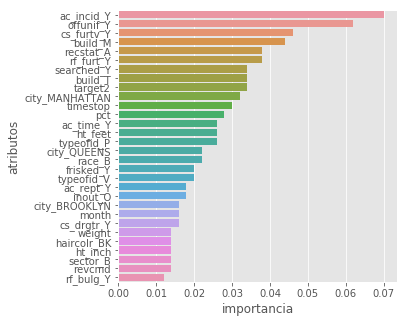

In [37]:
sns.barplot(data=df_30, x='importancia', y='atributos')

Entrenamos el Adaboost, con las 30 variables seleccionadas

In [38]:
# Entrenamos el decision stump
decision_stump_x = DecisionTreeClassifier(max_depth=1,random_state=16984).fit(x_train[atributos_30], y_train)
# Entrenamo el clasificador con adaptive boosting
Adaboost_model_30 = GridSearchCV(AdaBoostClassifier(base_estimator=decision_stump_x,random_state=16984),{'learning_rate':[0.01,0.1,0.5],'n_estimators':[50, 100, 500, 1000, 2000]},cv=2,n_jobs=-1).fit(x_train[atributos_30], y_train)

In [39]:
Adaboost_model_30.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=16984,
                            

In [40]:
y_hat1 = Adaboost_model_30.best_estimator_.predict(x_test[atributos_30])
print(classification_report(y_test, y_hat1))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4438
           1       0.61      0.37      0.46       309

    accuracy                           0.94      4747
   macro avg       0.78      0.68      0.72      4747
weighted avg       0.93      0.94      0.94      4747



Este es el modelo predicho con los 30 atributos más relevantes. Sin embargo podemos ver que este modelo, obtiene menor precisión que el modelo inicial. obteniendo 3% de precision menos que el modelo inicial (64%), sobre la clase relevante. el original con oversampling presenta mejores metricas f1

Agrupamos las probabilidad por ciudad raza y sexo

In [41]:
#Sacamos la probabilidad conjunta, para obtener las probabilidades por raza, sexo y barrio
df_agrupado = df_save_2009.copy(deep=True)
y_hat1= Adaboost_model_over.best_estimator_.predict(df_train.drop(columns=['target1','year']))
df_agrupado['prob'] = y_hat1
df_agrupado.shape, df_clean_recod.shape

((4636, 75), (9383, 111))

In [42]:
df_agrupado.groupby(by=['sex','race','city']).mean()['prob']

sex  race  city         
F    A     BRONX            0.000000
           BROOKLYN         0.000000
           MANHATTAN        0.666667
           QUEENS           0.000000
           STATEN ISLAND    0.000000
     B     BRONX            0.130435
           BROOKLYN         0.079365
           MANHATTAN        0.147059
           QUEENS           0.050000
           STATEN ISLAND    0.000000
     I     BROOKLYN         0.000000
     P     BRONX            0.000000
           BROOKLYN         0.000000
           MANHATTAN        0.200000
           QUEENS           0.000000
     Q     BRONX            0.000000
           BROOKLYN         0.052632
           MANHATTAN        0.071429
           QUEENS           0.000000
           STATEN ISLAND    0.000000
     U     QUEENS           0.000000
     W     BRONX            0.000000
           BROOKLYN         0.000000
           MANHATTAN        0.000000
           QUEENS           0.000000
           STATEN ISLAND    0.000000
     Z     BR

En general, podemos que la gente de sexo no identificado y de raza no identificada en manhattan, tiene la probabilidad más alta de ser arrestada. De las mujeres: Asiaticas y negros hispanicos en manhattan, son las que presentan mayor probabilidad de arresto (66% y 20% respectivamente). De los hombres, los negros- hispanicos, tienen mayor probabilidad de ser arrestados en un procedimiento , en la ciudad de Manhattan, seguido de otros en Brooklin ( 15%)

### Generamos los 5 modelos predictivos: Para eso, hacemos un pre-procesamiento de la data. Escalamos las variables.

In [43]:
#escalamos la data
from sklearn.preprocessing import StandardScaler

df_clean_recod2 = df_clean_recod
df_clean_recod2 = df_clean_recod2.reset_index()
df_clean_recod2.drop(columns='index',inplace=True)


sc = StandardScaler()
col_sc = list(df_clean_recod.columns)
col_sc.remove('year')
col_sc.remove('target2')

df_recoded_scale = pd.DataFrame(sc.fit_transform(df_clean_recod[col_sc]), columns = col_sc)

df_recoded_scale['year']= df_clean_recod2['year']
df_recoded_scale['target2']= df_clean_recod2['target2']


Dividimos las muestras en train y test, a su vez dividimos en variables dependientes e independientes

In [44]:
#Volvemos a dividir las muestras de entrenamiento y testeo
df_train = df_recoded_scale.query("year==2009")
df_test = df_recoded_scale.query("year==2010")

#separamos las variables en Y y X segun los dataframe
y_train = df_train['target2']
x_train = df_train.drop(['target2','year'], axis=1)
y_test = df_test['target2']
x_test = df_test.drop(['target2','year'], axis=1)

Exploramos la distribución de la variable target2

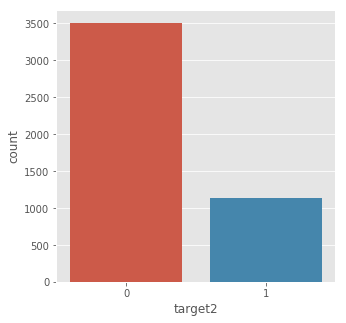

In [45]:
sns.countplot(y_train)

Nos enfrentamos a un desbalance de clases. Por tanto se rebalancean las clases mediante un oversampling, y se pasa a correr los modelos, sobre las bases rebalanceadas

In [46]:
oversmp = SMOTE(random_state=16984, ratio='minority')
x_train_oversmp, y_train_oversmp = oversmp.fit_sample(x_train, y_train)

## ADABOOST

In [47]:
# Entrenamos el decision stump
decision_stump = DecisionTreeClassifier(max_depth=1,random_state=16984).fit(x_train_oversmp, y_train_oversmp)
# Entrenamo el clasificador con adaptive boosting
Adaboost_model = GridSearchCV(AdaBoostClassifier(base_estimator=decision_stump,random_state=16984),{'learning_rate':[0.01,0.1,0.5],'n_estimators':[50, 100, 500, 1000, 2000]},cv=2,n_jobs=-1).fit(x_train_oversmp, y_train_oversmp)

In [48]:
Adaboost_model.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=16984,
                            

In [49]:
#vemos los resultados del adaboost
print(classification_report(y_test, Adaboost_model.best_estimator_.predict(x_test)))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3643
           1       0.50      0.46      0.48      1104

    accuracy                           0.77      4747
   macro avg       0.67      0.66      0.66      4747
weighted avg       0.76      0.77      0.76      4747



## Naive Bayes

In [50]:
# importamos los módulos de sklearn
from sklearn.naive_bayes import BernoulliNB

nb_classifier = BernoulliNB()
nb_fit=nb_classifier.fit(x_train_oversmp, y_train_oversmp)


In [51]:
print(classification_report(y_test, nb_classifier.predict(x_test)))

              precision    recall  f1-score   support

           0       0.90      0.67      0.77      3643
           1       0.41      0.77      0.54      1104

    accuracy                           0.69      4747
   macro avg       0.66      0.72      0.65      4747
weighted avg       0.79      0.69      0.72      4747



In [52]:
#mejora bastante

## Arboles de clasificación

In [53]:
dec_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),{'min_samples_split': np.linspace(0.1, 1.0, 5),'max_features': np.linspace(1,x_train_oversmp.shape[1],5, dtype='int')},cv=2, scoring='f1_macro',n_jobs=-1).fit(x_train_oversmp, y_train_oversmp)

In [54]:
dec_tree_grid_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=82, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.775,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [55]:
print(classification_report(y_test, dec_tree_grid_cv.predict(x_test)))

              precision    recall  f1-score   support

           0       0.96      0.56      0.71      3643
           1       0.39      0.92      0.55      1104

    accuracy                           0.65      4747
   macro avg       0.67      0.74      0.63      4747
weighted avg       0.83      0.65      0.67      4747



## Regresion logistica

In [56]:
from sklearn.linear_model import LogisticRegression

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], "fit_intercept":[True,False]}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=16984)
logreg_cv=GridSearchCV(logreg,grid,cv=2, scoring='f1', n_jobs=-1)
logreg_cv.fit(x_train_oversmp, y_train_oversmp)
logreg_cv.best_params_

{'C': 0.01, 'fit_intercept': True, 'penalty': 'l1'}

In [57]:
print(classification_report(y_test, logreg_cv.predict(x_test)))

              precision    recall  f1-score   support

           0       0.96      0.56      0.71      3643
           1       0.39      0.92      0.55      1104

    accuracy                           0.65      4747
   macro avg       0.67      0.74      0.63      4747
weighted avg       0.83      0.65      0.67      4747



## SVM

In [58]:
from sklearn.svm import SVC

SVM_grid = GridSearchCV(SVC(kernel='rbf'),{'C':[.01, .1, 1, 10, 100],'gamma':[0.0001, 0.01,0.1, 1, 10, 100]},cv=2,n_jobs=-1).fit(x_train_oversmp, y_train_oversmp)

In [59]:
SVM_grid.best_params_

{'C': 10, 'gamma': 0.1}

In [60]:
print(classification_report(y_test, SVM_grid.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3643
           1       0.00      0.00      0.00      1104

    accuracy                           0.77      4747
   macro avg       0.38      0.50      0.43      4747
weighted avg       0.59      0.77      0.67      4747



#### Finalmente, escogemos los dos modelos con mayor f1-score, teniendo en cuenta que prediga algo en la clase relevante, los modelos escogidos son el ADAboost con clases rebalanceadas (oversampling), y el clasificador Bayesiano Ingenuo, cuyas metricas promedio ponderadas del f1 son 76% y 72% respectivamente, muy por sobre las metricas reportadas por los otros modelos.

In [61]:
#pickle and dump de modelos
pickle.dump(Adaboost_model.best_estimator_, open('Adaboost.sav', 'wb'))
pickle.dump(nb_fit, open('Naive_Bayes.sav', 'wb'))
pickle.dump(x_train_oversmp, open('x_train.sav', 'wb'))
pickle.dump(x_test, open('x_test.sav', 'wb'))
pickle.dump(y_train_oversmp, open('y_train.sav', 'wb'))
pickle.dump(y_test, open('y_test.sav', 'wb'))